<pre>We will compute AUROC = Area Under the Receiver Operating Characteristic curve.
We will compute it using our own code and then use sklearn package to validate our scores.</pre>
#### Sections:

1. We will build a basic classifier model on titanic dataset
2. We will Compute the auc and roc_auc_score
3. We will Compute the auc and roc_auc_score using sklearn for validation
4. Plot both the metrics together for comparision

### Section 1: We will build a basic classifier model on titanic dataset

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
np.random.seed(42)

In [3]:
## Loading data and creating features. NOTE: df_test won't get used in this notebook

In [4]:
df_train = pd.read_csv('../data/titanic_train.csv')
df_test = pd.read_csv('../data/titanic_test.csv')

In [5]:
df_all = pd.concat((df_train, df_test), axis=0, ignore_index=True)

In [6]:
df_all = df_all.replace([np.inf, -np.inf], np.nan)

In [7]:
df_all['Age'].fillna(df_all['Age'].mean(), inplace=True)

In [8]:
df_all['Fare'] = df_all['Fare'].fillna(df_all['Fare'].mean())

In [9]:
df_all['has_cabin'] = df_all['Cabin'].apply(lambda val: 0 if pd.isnull(val) else 1)

In [10]:
df_all.shape, df_test.shape

((1309, 13), (418, 11))

In [11]:
df_all.columns

Index(['Age', 'Cabin', 'Embarked', 'Fare', 'Name', 'Parch', 'PassengerId',
       'Pclass', 'Sex', 'SibSp', 'Survived', 'Ticket', 'has_cabin'],
      dtype='object')

In [12]:
df_all = df_all[['Age', 'SibSp', 'Parch', 'Survived', 'Embarked', 'Pclass', 'Sex',
                 'Fare', 'has_cabin', 'PassengerId']]

In [13]:
df_all.set_index('PassengerId', inplace=True)

In [14]:
df_all['Sex'] = df_all['Sex'].map({'male':0, 'female':1})

In [15]:
df_all = pd.concat([df_all, pd.get_dummies(df_all['Embarked'])], axis=1)
df_all.drop('Embarked', axis=1, inplace=True)

In [16]:
df_train = df_all[:df_train.shape[0]]
df_test = df_all[df_train.shape[0]:]

In [17]:
df_train.shape, df_test.shape

((891, 11), (418, 11))

In [18]:
df_train.head(5)

,Age,SibSp,Parch,Survived,Pclass,Sex,Fare,has_cabin,C,Q,S
PassengerId,,,,,,,,,,,
1,22.0,1,0,0.0,3,0,7.2500,0,0,0,1
2,38.0,1,0,1.0,1,1,71.2833,1,1,0,0
3,26.0,0,0,1.0,3,1,7.9250,0,0,0,1
4,35.0,1,0,1.0,1,1,53.1000,1,0,0,1
5,35.0,0,0,0.0,3,0,8.0500,0,0,0,1


In [19]:
X_train, X_test = train_test_split(df_train, test_size=0.3)

In [20]:
Y_train = X_train.pop('Survived')
Y_test = X_test.pop('Survived')

In [21]:
## build a classifier model

In [22]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
% matplotlib inline

In [23]:
lw = 1 # line width for plt

In [24]:
model = RandomForestClassifier()
model = model.fit(X_train, Y_train)

In [25]:
# predict_proba will give probability for each class 0, 1.
# We only need valeus for calss 1
y_pred_test = model.predict_proba(X_test)[:,1]

### Section 2: We will Compute the auc and roc_auc_score

In [26]:
# we will compute ROC and Auc_ROC values

In [27]:
# we are setting thresholds as 0 to 1 with an increment of 0.05
# 1.05 has been taken as an outside of the boundary threshold
thresholds = list(reversed([i/100 for i in range(0, 106, 5)]))

In [28]:
total_positive = len(Y_test[Y_test == 1])
total_negative = len(Y_test[Y_test == 0])

In [29]:
total_positive, total_negative # total number of 

(111, 157)

In [30]:
# The idea is to find out at each threshold value what percentage of true positive and false positive 
# cases are detected
# Ideally we want a threshold for which all all true positive cases are detected and no true negative 
# cases are detected
tpr_computed = []
fpr_computed = []
for t_val in thresholds:
    values = y_pred_test >= t_val
    positive_count = sum(Y_test[values] == 1)
    negative_count = len(Y_test[values]) - sum(Y_test[values] == 1)
    tpr_computed.append(positive_count/total_positive)
    fpr_computed.append(negative_count/total_negative)

In [31]:
prev_fpr_value = 0
prev_tpr_value = 0
roc_auc_computed = 0
for fpr, tpr in zip(fpr_computed, tpr_computed):
    # for each change in fpr there is a change in tpr
    # this will form a rectangle and we will compute the area of the rectangle.
    # plus the top part of the rectangle is sort of like a traiangle we will adjust for that.
    fpr_change = (fpr - prev_fpr_value)
    tpr_change = tpr - prev_tpr_value
    roc_auc_computed += prev_tpr_value * fpr_change + 1/2 * fpr_change * tpr_change
    prev_fpr_value = fpr
    prev_tpr_value = tpr

In [32]:
roc_auc_computed # the auc that we have computed

0.8348252711310036

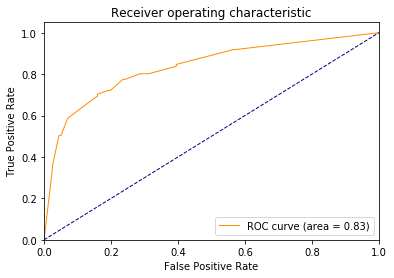

In [33]:
plt.plot(fpr_computed, tpr_computed, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_computed)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### Section 3: We will Compute the auc and roc_auc_score using sklearn for validation

In [34]:
# Let's compute the metrics using sklearn library
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [35]:
roc_auc_score(Y_test, y_pred_test)

0.8342801400126241

In [36]:
fpr, tpr, _ = roc_curve(Y_test, y_pred_test)
roc_auc = auc(fpr, tpr)

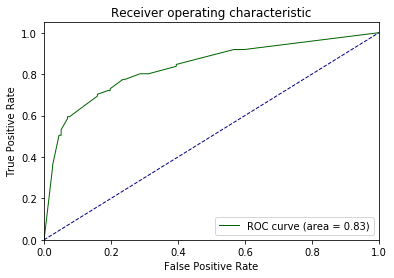

In [37]:
plt.plot(fpr, tpr, color='darkgreen',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### Section 4: Plot both the metrics together for comparision

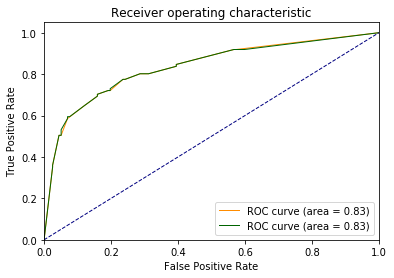

In [38]:
plt.plot(fpr_computed, tpr_computed, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_computed)
plt.plot(fpr, tpr, color='darkgreen',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [39]:
# Almost overlaps

In [54]:
print("Threshold | TPR  | FPR")
for a, b, c in zip(tpr_computed, fpr_computed, thresholds):
    print("     {0:.2f} |".format(c), "{0:.2f} |".format(a), "{0:.2f}".format(b))

Threshold | TPR  | FPR
     1.05 | 0.00 | 0.00
     1.00 | 0.35 | 0.03
     0.95 | 0.36 | 0.03
     0.90 | 0.50 | 0.04
     0.85 | 0.50 | 0.05
     0.80 | 0.59 | 0.07
     0.75 | 0.59 | 0.07
     0.70 | 0.65 | 0.12
     0.65 | 0.65 | 0.12
     0.60 | 0.69 | 0.16
     0.55 | 0.70 | 0.16
     0.50 | 0.72 | 0.19
     0.45 | 0.72 | 0.20
     0.40 | 0.77 | 0.24
     0.35 | 0.77 | 0.24
     0.30 | 0.80 | 0.29
     0.25 | 0.80 | 0.31
     0.20 | 0.84 | 0.39
     0.15 | 0.85 | 0.39
     0.10 | 0.92 | 0.57
     0.05 | 0.92 | 0.57
     0.00 | 1.00 | 1.00


<hr>
<pre>
Q> Now say we wan't to find out at what threshold value do we get 60 % true postive case and what % 
of negative cases will come along with it?

A> For a threshold value of 0.75 we get close to 59% of true positive cases and 0.07 % of false positive case.

PS: To get exactly 60% we will have to go granular between 0.70 and 0.75 threshold.
</pre>